# MRS Band 1C Wavelength Calibration Analysis
Script written by Ioannis Argyriou (Institute of Astronomy, KU Leuven)  
Creation date 13th October 2017  

This notebook shows how to derive/calibrate the wavelength solution for band 1C based on the RAL FTS and FM etalon data.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
# import modules
import funcs
import mrsobs
from distortionMaps import d2cMapping

import numpy as np
import scipy.interpolate as scp_interpolate
from scipy.optimize import curve_fit
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [3]:
# set directories
workDir  = "/Users/ioannisa/Desktop/python/miri_devel/"
cdpDir   = workDir+"cdp_data/"
lvl2path = workDir+"FM_data/LVL2/"
MRSWaveCalDir = workDir+"MRSWaveCal/" 
FTSlinefits   = MRSWaveCalDir+"FTS_ET_linefits/"
# *** AL: Change these to more general folders like"./data_for_notebook_test/" that we can all have

In [4]:
# give analysis inputs
band = '1C'                     # spectral band under investigation
lamblower,lambupper = 6.5,7.7   # nominal wavelength range of band 1C
islice    = 10                  # slice number (equivalent to beta position)
alpha_pos = 0.                  # along-slice position, [arcsec]

The wavelength calibration in band 1C is performed in three steps. First a reference wavelength/pixel pair is determined. This is done using the long-wave-pass (LWP) filter transmission. By comparing the transmission of the filter determined from the lab and with the MRS, a reference wavelength can be matched to a reference pixel on the MRS detector. Let's look at the lab and MRS LWP filter transmission.

<IPython.core.display.Javascript object>


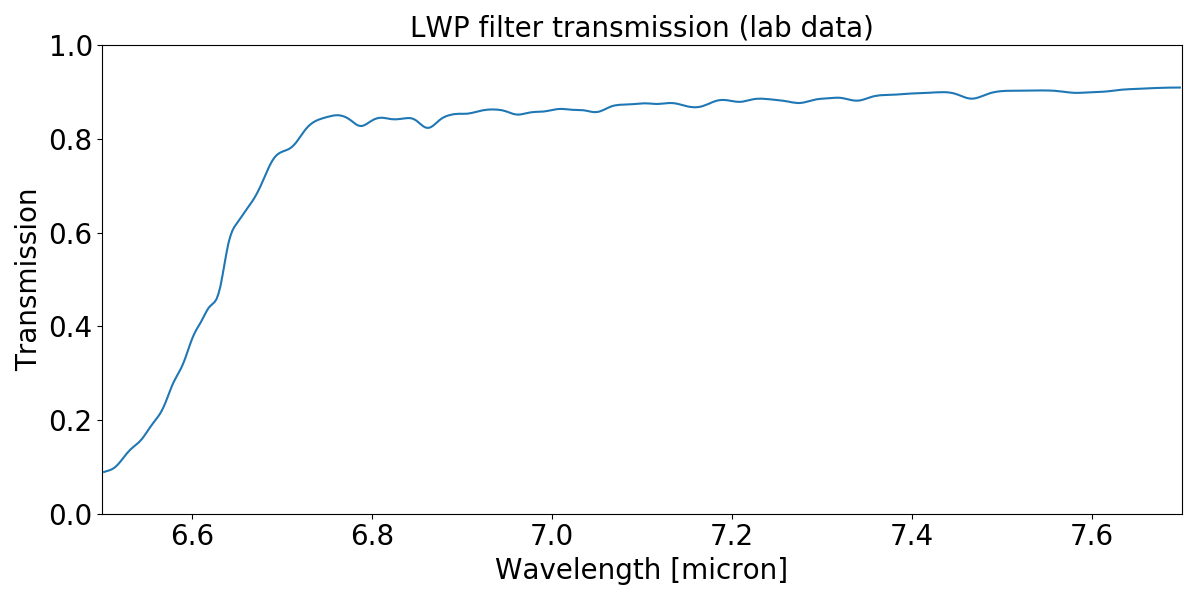

In [5]:
# Import dichroic transmission data
# -->Read the measured transmission curves from the data files
# first column is wavelength [micrometer]
# second and third columns are room temperature transmissions
# fourth column is 35K transmission
LWPwvnr,LWPtransm = np.genfromtxt(MRSWaveCalDir + "lwp_filter.txt", skip_header = 15, skip_footer=1, usecols=(0,3), delimiter = '',unpack='True')
LWPwave = 10000./LWPwvnr
LWPtransm = LWPtransm/100. # convert percentage to decimal
sel = (LWPwave>=lamblower) & (LWPwave<=lambupper)

# plot transmissions
plt.figure(figsize=(12,6))
plt.plot(LWPwave[sel],LWPtransm[sel])
plt.xlim(lamblower,lambupper)
plt.ylim(0,1.0)
plt.title('LWP filter transmission (lab data)',fontsize=20)
plt.xlabel('Wavelength [micron]',fontsize=20)
plt.ylabel('Transmission',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

<IPython.core.display.Javascript object>


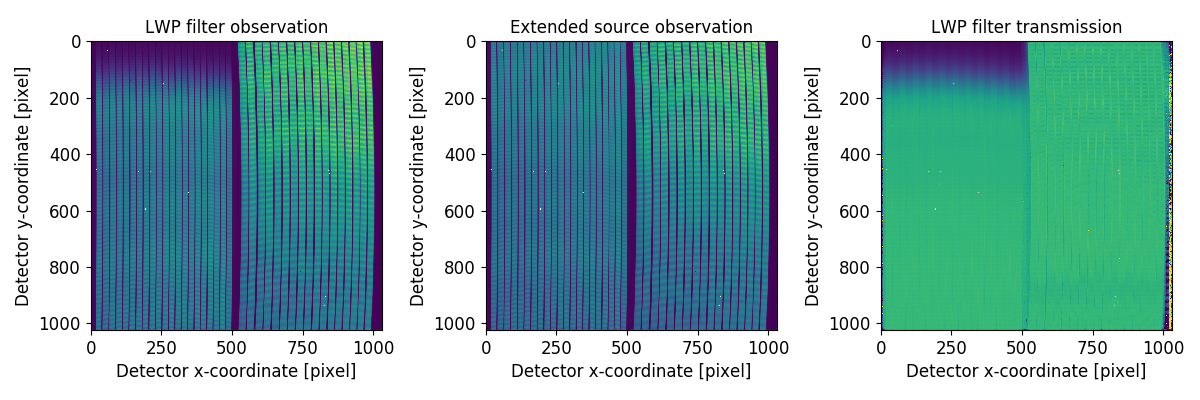

In [6]:
# Import MRS observations
# -->MRS detector images processed with DHAS 9.4.4 miri_sloper only
# lwp_filter_img: LWP filter extended obs (LWP transm x 800K BB), ext_source_img: 800K BB extended source config
# ***** AL: Are these corrected of background? They should be, right? <-- The observations are now background corrected!

lwp_filter_img,ext_source_img,bkg_img = mrsobs.FM_MTS_800K_BB_MRS_OPT_08(lvl2path,wp_filter='LWP',output='img')
lwp_transmission_img = (lwp_filter_img-bkg_img)/(ext_source_img-bkg_img)

# plot
fig,axs = plt.subplots(1,3,figsize=(12,4))
axs[0].imshow(lwp_filter_img)
axs[1].imshow(ext_source_img)
axs[2].imshow(lwp_transmission_img,vmin=0,vmax=1.4)
for plot in range(3):
    axs[plot].set_xlabel('Detector x-coordinate [pixel]',fontsize=12)
    axs[plot].set_ylabel('Detector y-coordinate [pixel]',fontsize=12)
    axs[plot].tick_params(axis='both',labelsize=12)
axs[0].set_title('LWP filter observation',fontsize=12)
axs[1].set_title('Extended source observation',fontsize=12)
axs[2].set_title('LWP filter transmission',fontsize=12)
plt.tight_layout()

In [7]:
# load distortion maps
d2cMaps   = d2cMapping(band,cdpDir)
sliceMap  = d2cMaps['sliceMap']
lambdaMap = d2cMaps['lambdaMap']
alphaMap  = d2cMaps['alphaMap']
nslices   = d2cMaps['nslices']
det_dims  = (1024,1032)

<IPython.core.display.Javascript object>


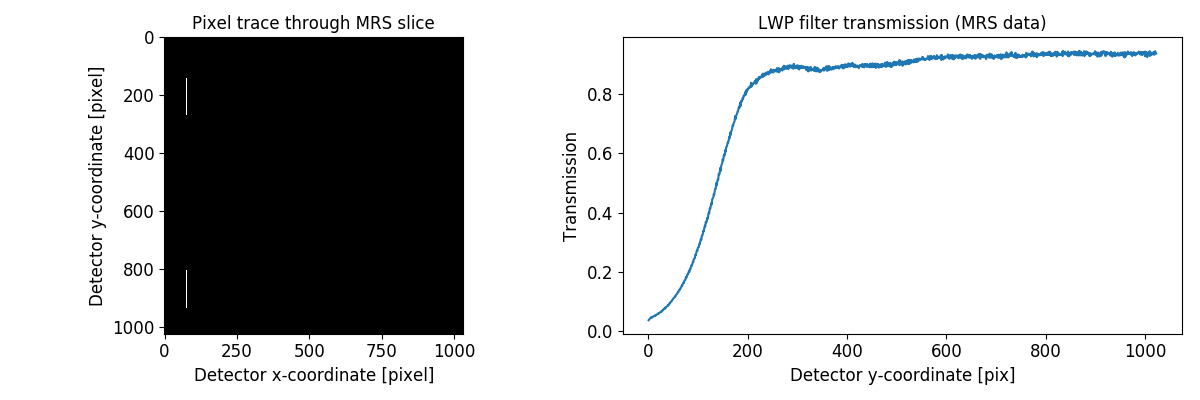

In [8]:
# take pixel trace along specified slice, specified alpha position
## ******* AL: Shall we use interpolation between closest alpha values? <-- This should result in a pixel to sub-pixel order improvement on the determination of the wavelength-pixel reference
ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=islice,alpha_pos=alpha_pos)

# plot trace
valid_img = np.zeros(det_dims)
valid_img[ypos,xpos] = 1.

fig,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].imshow(valid_img,cmap='gray')
axs[0].set_title('Pixel trace through MRS slice',fontsize=12)
axs[0].set_xlabel('Detector x-coordinate [pixel]',fontsize=12)
axs[0].set_ylabel('Detector y-coordinate [pixel]',fontsize=12)
axs[1].plot(lwp_transmission_img[ypos,xpos])
axs[1].set_title('LWP filter transmission (MRS data)',fontsize=12)
axs[1].set_xlabel('Detector y-coordinate [pix]',fontsize=12)
axs[1].set_ylabel('Transmission',fontsize=12)
for plot in range(2): axs[plot].tick_params(axis='both',labelsize=12)
plt.tight_layout()

Below we compare the lab and MRS determined filter transmissions. Since the steep gradient part of the transmission in the lab data shows erratic changes of slope (compared to the MRS data), rather than defining a cut-off on the steep gradient part of the curve, we determine the reference wavelength/pixel pair at the location where the filter transmission flattens out, i.e. where the gradient of the curve is zero. A spline is fitted through the MRS data to remove the small amplitude high-frequency noise in the data.  
  
The result of the following analysis is the definition of a reference wavelength/pixel pair.

<IPython.core.display.Javascript object>


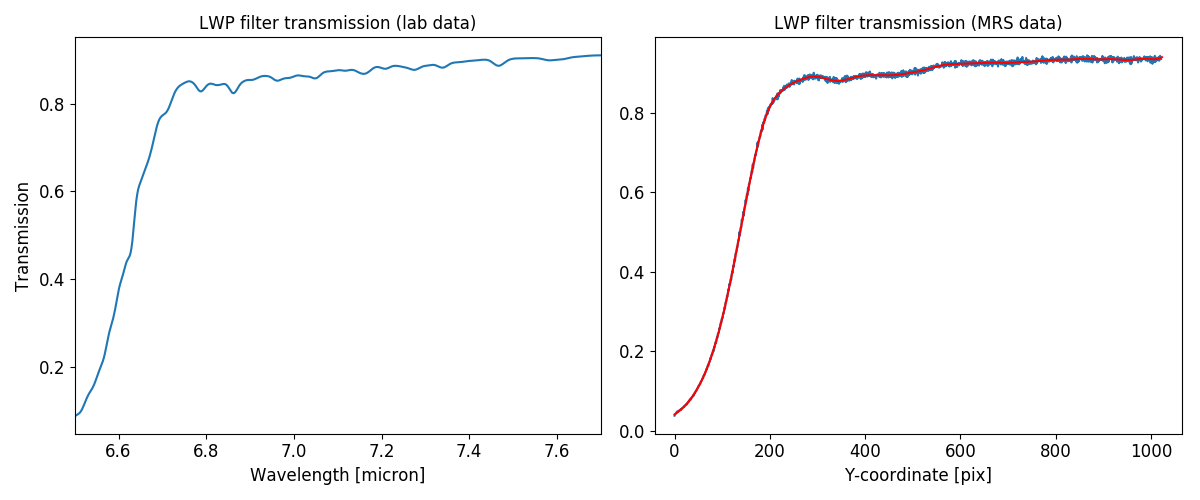

<IPython.core.display.Javascript object>


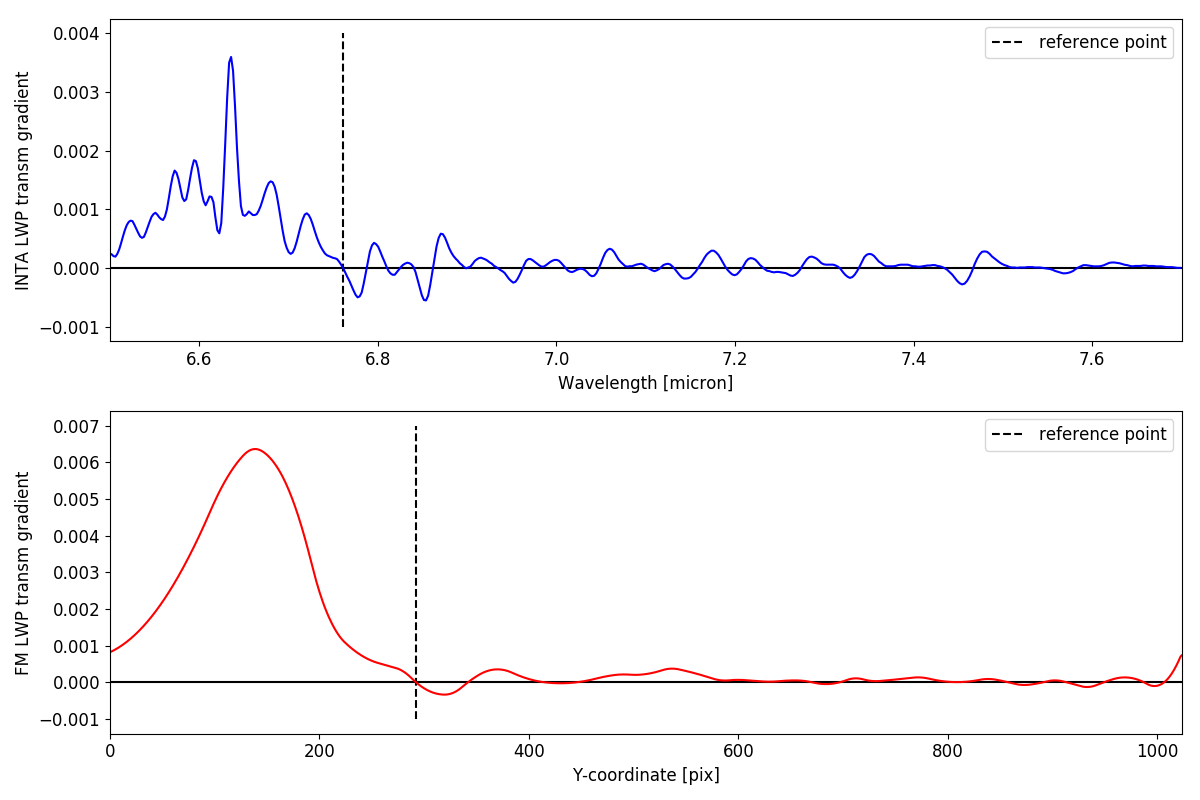

Reference wavelength: 6.761 micron
Reference pixel: 292.292 pix


In [9]:
### > Yannis fit (spline) of the reference point
# load spectrum from desired location and carry-out analysis
sci_fm_data = lwp_transmission_img[ypos,xpos]
sci_fm_data[np.isnan(sci_fm_data)] = 0

# fit spline to data (smoother signal profile)
spl = scp_interpolate.UnivariateSpline(np.arange(len(sci_fm_data[1:-1]) ),sci_fm_data[1:-1])
spl.set_smoothing_factor(0.02)

fig,axs = plt.subplots(1,2,figsize=(12,5))
axs[0].plot(LWPwave[sel],LWPtransm[sel])
axs[0].set_xlim(lamblower,lambupper)
axs[0].set_xlabel('Wavelength [micron]',fontsize=12)
axs[0].set_ylabel('Transmission',fontsize=12)
axs[0].set_title('LWP filter transmission (lab data)',fontsize=12)
axs[1].plot(sci_fm_data[np.nonzero(sci_fm_data)])
axs[1].plot(spl(np.arange(len(sci_fm_data))),'r')
axs[1].set_xlim(-40,1064)
axs[1].set_xlabel('Y-coordinate [pix]',fontsize=12)
axs[1].set_title('LWP filter transmission (MRS data)',fontsize=12)
for plot in range(2): axs[plot].tick_params(axis='both',labelsize=12)
plt.tight_layout()

# Reference wavelength/pixel pair defined by matching zero-crossing of gradient of INTA and FM LWP transmission
LWPgrad = np.gradient(LWPtransm[sel],LWPwave[sel])
LWPsigns = np.sign(LWPgrad)
sci_fm_data_grad = np.gradient(spl(np.arange(len(sci_fm_data))))
sci_fm_data_signs = np.sign(sci_fm_data_grad)

LWPzerocrossing = np.where(np.abs(np.diff(LWPsigns)) == 2)[0]
sci_fm_data_zerocrossing = np.where(np.abs(np.diff(sci_fm_data_signs)) == 2)[0]

x0 = LWPwave[sel][LWPzerocrossing[0]]
x1 = LWPwave[sel][LWPzerocrossing[0]+1]
y0 = LWPgrad[LWPzerocrossing[0]]
y1 = LWPgrad[LWPzerocrossing[0]+1]
a = (y1-y0)/(x1-x0)
cutofflamb = (-y0/a) + x0

x0 = sci_fm_data_zerocrossing[0]
x1 = np.arange(len(sci_fm_data))[sci_fm_data_zerocrossing[0]+1]
y0 = sci_fm_data_grad[sci_fm_data_zerocrossing[0]]
y1 = sci_fm_data_grad[sci_fm_data_zerocrossing[0]+1]
a = (y1-y0)/(x1-x0)
cutoffpix = (-y0/a) + x0

# plot result
fig,axs = plt.subplots(2,1,figsize=(12,8))
axs[0].plot(LWPwave[sel],np.gradient(LWPtransm[sel],LWPwave[sel]),'b')
axs[0].hlines(0,lamblower,lambupper)
axs[0].vlines(cutofflamb,-0.001,0.004,linestyle='dashed',label='reference point')
axs[0].set_xlim(lamblower,lambupper)
axs[1].plot(np.gradient(spl(np.arange(1024))),'r')
axs[1].hlines(0,0,1024)
axs[1].vlines(cutoffpix,-0.001,0.007,linestyle='dashed',label='reference point')
axs[1].set_xlim(0,1023)
axs[0].set_xlabel('Wavelength [micron]',fontsize=12)
axs[0].set_ylabel('INTA LWP transm gradient',fontsize=12)
axs[1].set_xlabel('Y-coordinate [pix]',fontsize=12)
axs[1].set_ylabel('FM LWP transm gradient',fontsize=12)
for plot in range(2): 
    axs[plot].tick_params(axis='both',labelsize=12)
    axs[plot].legend(loc='upper right',fontsize=12)
plt.tight_layout()

print 'Reference wavelength: {} micron'.format(round(cutofflamb,3))
print 'Reference pixel: {} pix'.format(round(cutoffpix,3))

### > Insert here Alvaro's fit of the reference point

<IPython.core.display.Javascript object>


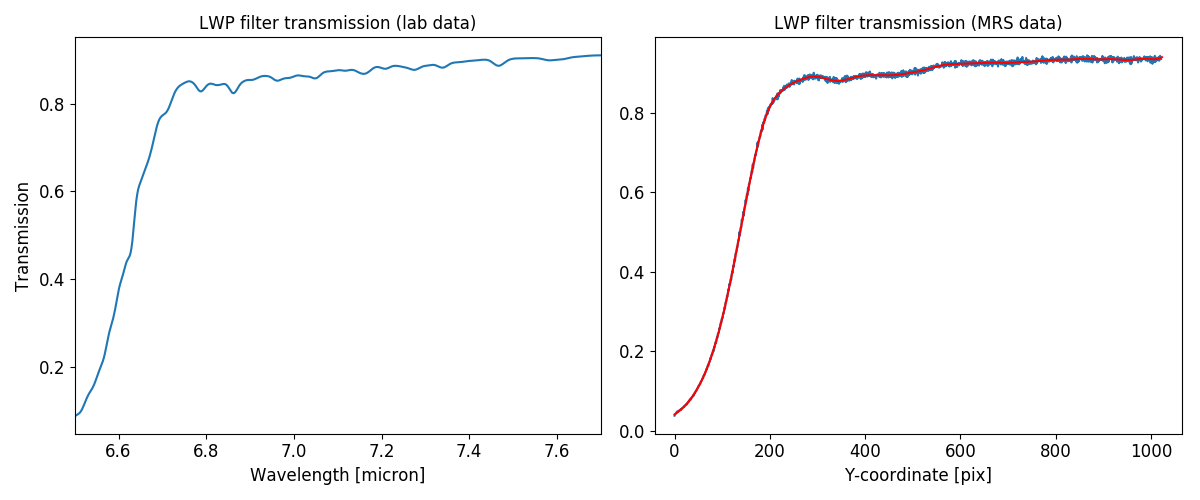

<IPython.core.display.Javascript object>


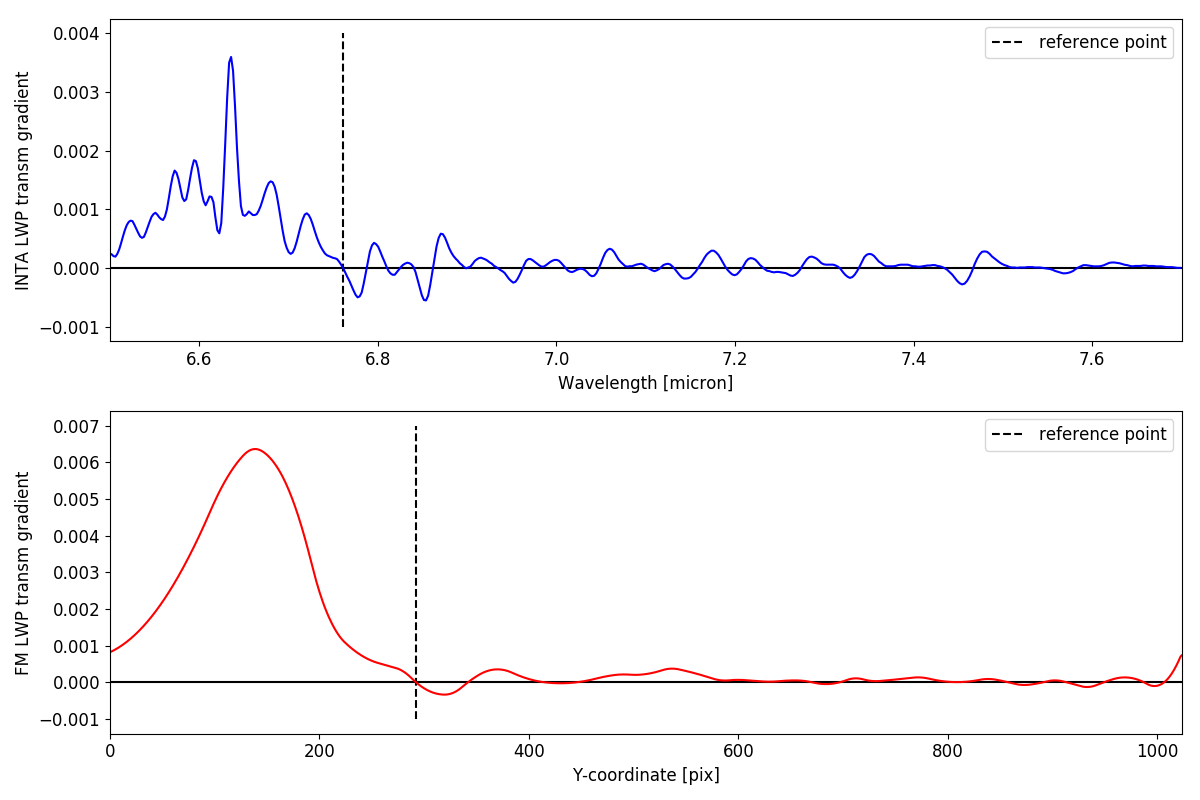

Reference wavelength: 6.761 micron
Reference pixel: 292.292 pix


In [10]:
# load spectrum from desired location and carry-out analysis
sci_fm_data = lwp_transmission_img[ypos,xpos]
sci_fm_data[np.isnan(sci_fm_data)] = 0

# fit spline to data (smoother signal profile) 
#### ****** AQUIIIIII!!!!
# fit spline to data (smoother signal profile)
spl = scp_interpolate.UnivariateSpline(np.arange(len(sci_fm_data[1:-1]) ),sci_fm_data[1:-1])
spl.set_smoothing_factor(0.02)

fig,axs = plt.subplots(1,2,figsize=(12,5))
axs[0].plot(LWPwave[sel],LWPtransm[sel])
axs[0].set_xlim(lamblower,lambupper)
axs[0].set_xlabel('Wavelength [micron]',fontsize=12)
axs[0].set_ylabel('Transmission',fontsize=12)
axs[0].set_title('LWP filter transmission (lab data)',fontsize=12)
axs[1].plot(sci_fm_data[np.nonzero(sci_fm_data)])
axs[1].plot(spl(np.arange(len(sci_fm_data))),'r')
axs[1].set_xlim(-40,1064)
axs[1].set_xlabel('Y-coordinate [pix]',fontsize=12)
axs[1].set_title('LWP filter transmission (MRS data)',fontsize=12)
for plot in range(2): axs[plot].tick_params(axis='both',labelsize=12)
plt.tight_layout()

# Reference wavelength/pixel pair defined by matching zero-crossing of gradient of INTA and FM LWP transmission
LWPgrad = np.gradient(LWPtransm[sel],LWPwave[sel])
LWPsigns = np.sign(LWPgrad)
sci_fm_data_grad = np.gradient(spl(np.arange(len(sci_fm_data))))
sci_fm_data_signs = np.sign(sci_fm_data_grad)

LWPzerocrossing = np.where(np.abs(np.diff(LWPsigns)) == 2)[0]
sci_fm_data_zerocrossing = np.where(np.abs(np.diff(sci_fm_data_signs)) == 2)[0]

x0 = LWPwave[sel][LWPzerocrossing[0]]
x1 = LWPwave[sel][LWPzerocrossing[0]+1]
y0 = LWPgrad[LWPzerocrossing[0]]
y1 = LWPgrad[LWPzerocrossing[0]+1]
a = (y1-y0)/(x1-x0)
cutofflamb = (-y0/a) + x0

x0 = sci_fm_data_zerocrossing[0]
x1 = np.arange(len(sci_fm_data))[sci_fm_data_zerocrossing[0]+1]
y0 = sci_fm_data_grad[sci_fm_data_zerocrossing[0]]
y1 = sci_fm_data_grad[sci_fm_data_zerocrossing[0]+1]
a = (y1-y0)/(x1-x0)
cutoffpix = (-y0/a) + x0

# plot result
fig,axs = plt.subplots(2,1,figsize=(12,8))
axs[0].plot(LWPwave[sel],np.gradient(LWPtransm[sel],LWPwave[sel]),'b')
axs[0].hlines(0,lamblower,lambupper)
axs[0].vlines(cutofflamb,-0.001,0.004,linestyle='dashed',label='reference point')
axs[0].set_xlim(lamblower,lambupper)
axs[1].plot(np.gradient(spl(np.arange(1024))),'r')
axs[1].hlines(0,0,1024)
axs[1].vlines(cutoffpix,-0.001,0.007,linestyle='dashed',label='reference point')
axs[1].set_xlim(0,1023)
axs[0].set_xlabel('Wavelength [micron]',fontsize=12)
axs[0].set_ylabel('INTA LWP transm gradient',fontsize=12)
axs[1].set_xlabel('Y-coordinate [pix]',fontsize=12)
axs[1].set_ylabel('FM LWP transm gradient',fontsize=12)
for plot in range(2): 
    axs[plot].tick_params(axis='both',labelsize=12)
    axs[plot].legend(loc='upper right',fontsize=12)
plt.tight_layout()

print 'Reference wavelength: {} micron'.format(round(cutofflamb,3))
print 'Reference pixel: {} pix'.format(round(cutoffpix,3))

In the second step of the wavelength calibration, the etalon lines of ET1A and ET1B Fabry-Pérot etalons, observed with the MRS and the RAL FTS, are fitted to determine the central wavelengths of the lines. The etalon lines of the FTS lab data were actually fitted in a different notebook, thus they are simply loaded in this notebook. We show the process of fitting the etalon lines in the MRS data below.

In [11]:
# Load etalon MRS and RAL FTS data files and data
# Etalon_1A FM data, band 1C/2C
sci_etalon1A_img = fits.open(MRSWaveCalDir+'EtalonFMdata_band1C/MIRFM1T00010843_1_495_SE_2011-05-18T00h47m06_LVL2.fits')[0].data[0,:,:]
bkg_etalon1A_img = fits.open(MRSWaveCalDir+'EtalonFMdata_band1C/MIRFM1T00010844_1_495_SE_2011-05-18T01h53m59_LVL2.fits')[0].data[0,:,:]

etalon1A_img = sci_etalon1A_img-bkg_etalon1A_img

# Etalon_1B FM data, band 1C/2C
sci_etalon1B_img = fits.open(MRSWaveCalDir+'EtalonFMdata_band1C/MIRFM1T00010943_1_495_SE_2011-05-20T03h23m04_LVL2.fits')[0].data[0,:,:]
bkg_etalon1B_img = fits.open(MRSWaveCalDir+'EtalonFMdata_band1C/MIRFM1T00010942_1_495_SE_2011-05-20T02h30m42_LVL2.fits')[0].data[0,:,:]

etalon1B_img = sci_etalon1B_img-bkg_etalon1B_img

# RAL Etalon data (need to extrapolate to operating temperatures (~35 K)?)
FTS_ET1A_linefits_file = FTSlinefits+'RAL_FTS_ET1A_FITPARAMS_07.01.00.fits'
FTS_ET1B_linefits_file = FTSlinefits+'RAL_FTS_ET1B_FITPARAMS_07.01.00.fits'

In [12]:
# Choose data regions
#--FM data
etalon1A_fm_data = etalon1A_img[ypos,xpos]
etalon1B_fm_data = etalon1B_img[ypos,xpos]

# Determine etalon peaks
#--FM Etalon_1A data
etalon1A_fm_data[np.isnan(etalon1A_fm_data)] = -1
FMetalon1A_peaks = funcs.find_peaks(etalon1A_fm_data,thres=0.1,min_dist=9)
etalon1A_fm_data[(etalon1A_fm_data == -1)] = np.nan
etalon1A_fm_data_noNaN = etalon1A_fm_data.copy()
etalon1A_fm_data_noNaN[np.isnan(etalon1A_fm_data)] = 0.

#--FM Etalon_1B data
etalon1B_fm_data[np.isnan(etalon1B_fm_data)] = -1
FMetalon1B_peaks = funcs.find_peaks(etalon1B_fm_data,thres=0.1,min_dist=0)
FMetalon1B_peaks = np.delete(FMetalon1B_peaks,[0,len(FMetalon1B_peaks)-1])
etalon1B_fm_data[(etalon1B_fm_data == -1)] = np.nan
etalon1B_fm_data_noNaN = etalon1B_fm_data.copy()
etalon1B_fm_data_noNaN[np.isnan(etalon1B_fm_data)] = 0.

print "Number of identified etalon lines :\n FM ET_1A etalon data: {} lines \n FM ET_1B etalon data: {} lines".format(len(FMetalon1A_peaks),len(FMetalon1B_peaks))

Number of identified etalon lines :
 FM ET_1A etalon data: 74 lines 
 FM ET_1B etalon data: 84 lines


<IPython.core.display.Javascript object>


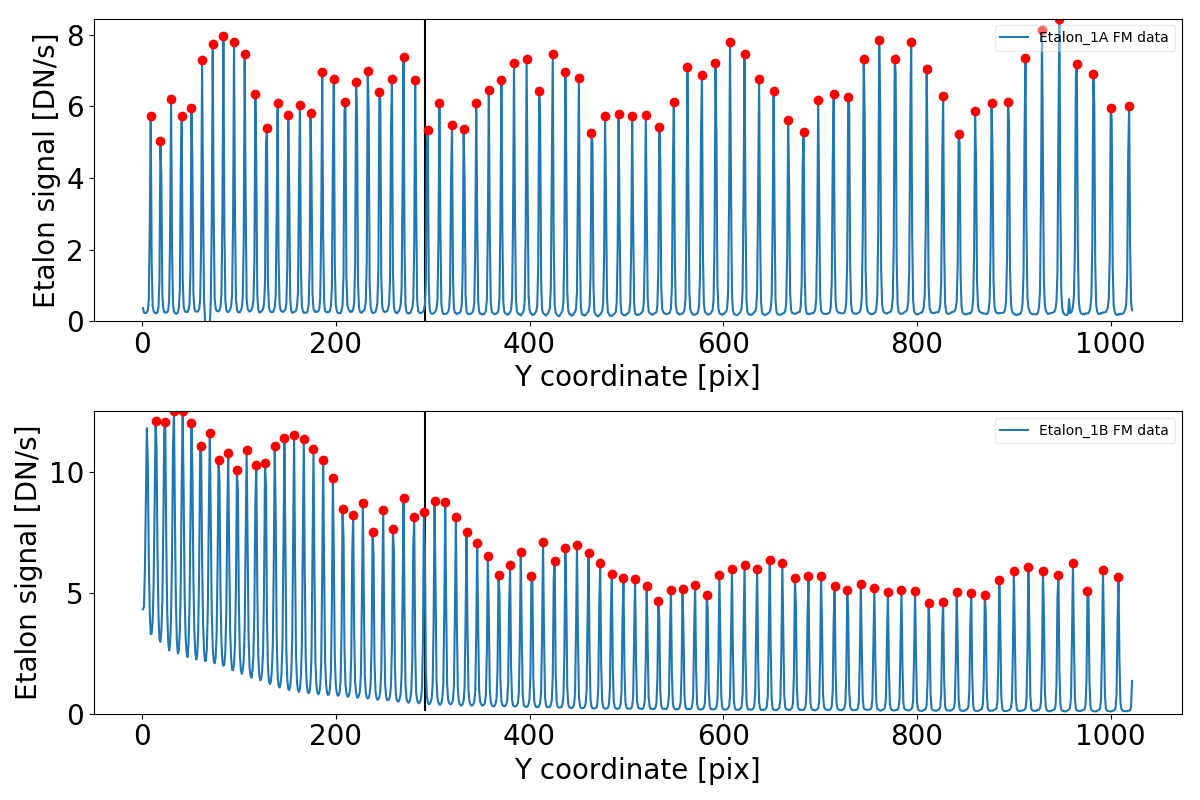

In [13]:
fig,axs = plt.subplots(2,1,figsize=(12,8))
axs[0].plot(etalon1A_fm_data,label='Etalon_1A FM data')
axs[0].plot(FMetalon1A_peaks,etalon1A_fm_data[FMetalon1A_peaks],'ro')
axs[0].vlines(cutoffpix,etalon1A_fm_data[~np.isnan(etalon1A_fm_data)].min(),etalon1A_fm_data[~np.isnan(etalon1A_fm_data)].max())
axs[0].set_ylim(0,etalon1A_fm_data[~np.isnan(etalon1A_fm_data)].max())
axs[1].plot(etalon1B_fm_data,label='Etalon_1B FM data')
axs[1].plot(FMetalon1B_peaks,etalon1B_fm_data[FMetalon1B_peaks],'ro')
axs[1].vlines(cutoffpix,etalon1B_fm_data[~np.isnan(etalon1B_fm_data)].min(),etalon1B_fm_data[~np.isnan(etalon1B_fm_data)].max())
axs[1].set_ylim(0,etalon1B_fm_data[~np.isnan(etalon1B_fm_data)].max())
for plot in range(2):
    axs[plot].set_xlabel('Y coordinate [pix]',fontsize=20)
    axs[plot].set_ylabel('Etalon signal [DN/s]',fontsize=20)
    axs[plot].tick_params(axis='both',labelsize=20)
    axs[plot].legend(loc='upper right',framealpha=0.4)
plt.tight_layout()


In [14]:
#-- Fit Etalon_1A lines in FM data
FMetalon1A_fitparams,FMetalon1A_fiterrors,fitting_flag,range_ini,range_fin = funcs.fit_etalon_lines(np.arange(det_dims[0]),etalon1A_fm_data_noNaN,FMetalon1A_peaks,fit_func='skewed_voight',sigma0=1.5,f0=0.5,a0=0.1)

# etalon line single parameters
linecenter = funcs.get_linecenter(FMetalon1A_fitparams,fitting_flag)
linefwhm   = funcs.get_FWHM(FMetalon1A_fitparams,fitting_flag)
lineskew   = funcs.get_skewness(FMetalon1A_fitparams,fitting_flag)

<IPython.core.display.Javascript object>


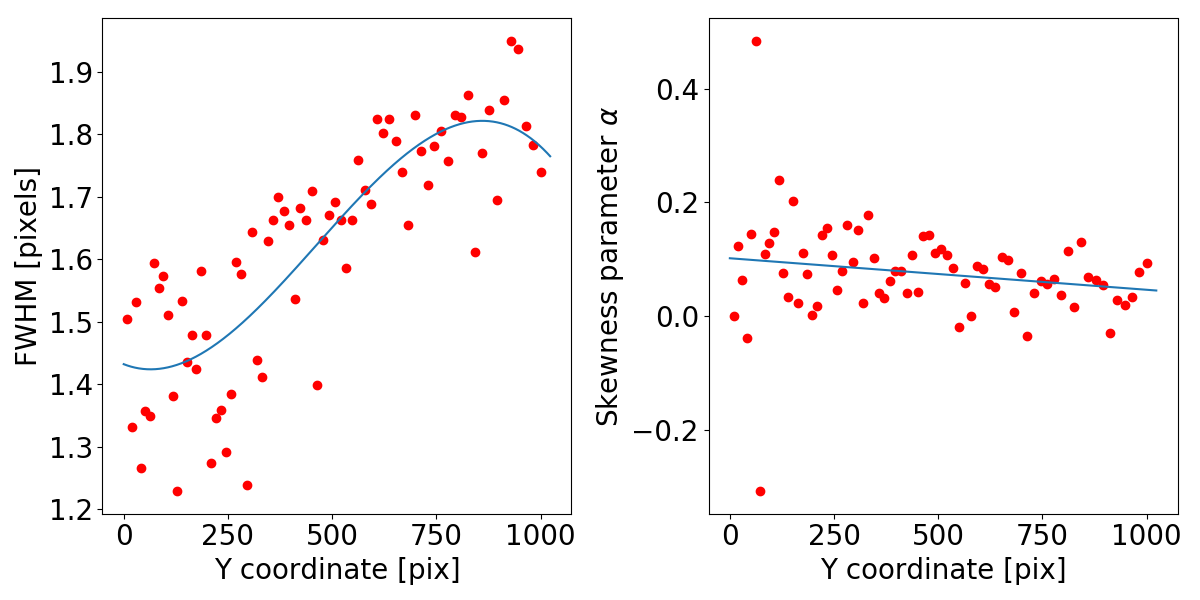

<IPython.core.display.Javascript object>


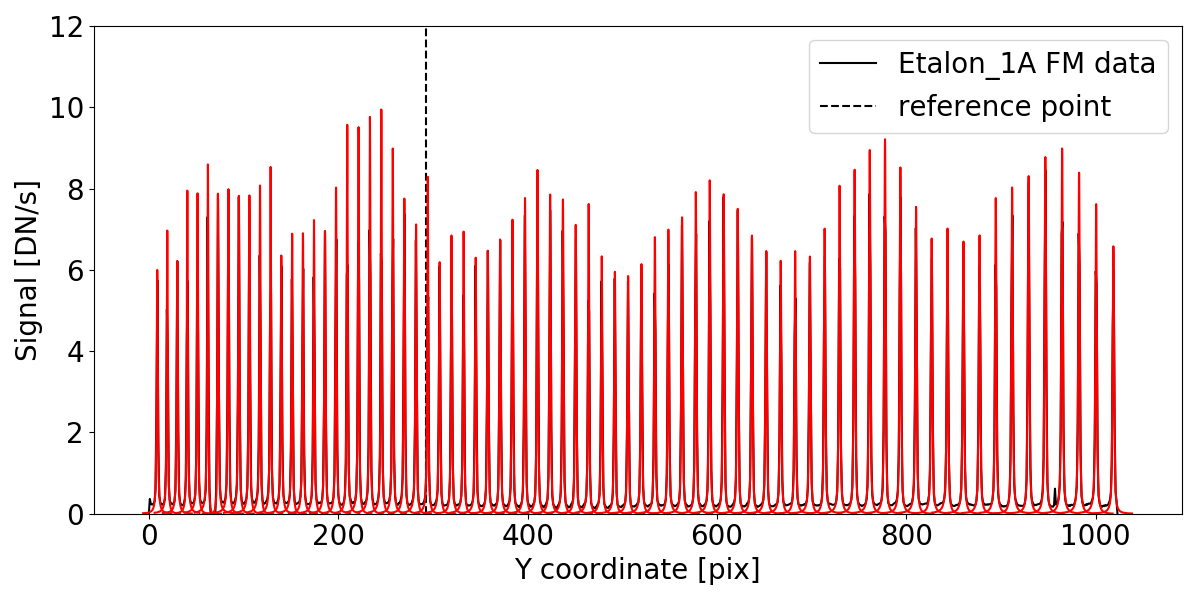

In [15]:
# plot results
sel1 = (np.abs(np.diff(np.array(linefwhm)))<np.inf)
popt1,pcov1 = curve_fit(funcs.order3polyfit,np.array(linecenter)[sel1],np.array(linefwhm)[sel1] )
sel2 = (np.abs(np.diff(np.array(lineskew))<0.5))
popt2,pcov2 = curve_fit(funcs.straight_line,np.array(linecenter)[sel2],np.array(lineskew)[sel2])

fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].plot(np.array(linecenter)[sel1],np.array(linefwhm)[sel1],'ro')
axs[0].plot(np.arange(len(etalon1A_fm_data_noNaN)),funcs.order3polyfit(np.arange(len(etalon1A_fm_data_noNaN)),*popt1))
axs[0].set_xlabel('Y coordinate [pix]',fontsize=20)
axs[0].set_ylabel(r'FWHM [pixels]',fontsize=20)
axs[0].tick_params(axis='both',labelsize=20)
axs[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs[1].plot(np.array(linecenter)[sel2],np.array(lineskew)[sel2],'ro')
axs[1].plot(np.arange(len(etalon1A_fm_data_noNaN)),funcs.straight_line(np.arange(len(etalon1A_fm_data_noNaN)),*popt2))
axs[1].set_xlabel('Y coordinate [pix]',fontsize=20)
axs[1].set_ylabel(r'Skewness parameter $\alpha$',fontsize=20)
axs[1].tick_params(axis='both',labelsize=20)
plt.tight_layout()

plt.figure(figsize=(12,6))
plt.plot(etalon1A_fm_data_noNaN,'k',label='Etalon_1A FM data')
plt.vlines(cutoffpix,0,25,linestyle='dashed',label='reference point')
funcs.plot_etalon_fit(FMetalon1A_fitparams,fitting_flag)
plt.ylim(0,12)
plt.xlabel('Y coordinate [pix]',fontsize=20)
plt.ylabel('Signal [DN/s]',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.legend(loc='upper right',fontsize=20)
plt.tight_layout()

In [16]:
#-- Fit Etalon_1B lines in FM data
FMetalon1B_fitparams,FMetalon1B_fiterrors,fitting_flag,range_ini,range_fin = funcs.fit_etalon_lines(np.arange(det_dims[0]),etalon1B_fm_data_noNaN,FMetalon1B_peaks,fit_func='skewed_voight',sigma0=5,f0=0.5,a0=0.1)

# etalon line single parameters
linecenter = funcs.get_linecenter(FMetalon1B_fitparams,fitting_flag)
linefwhm   = funcs.get_FWHM(FMetalon1B_fitparams,fitting_flag)
lineskew   = funcs.get_skewness(FMetalon1B_fitparams,fitting_flag)

<IPython.core.display.Javascript object>


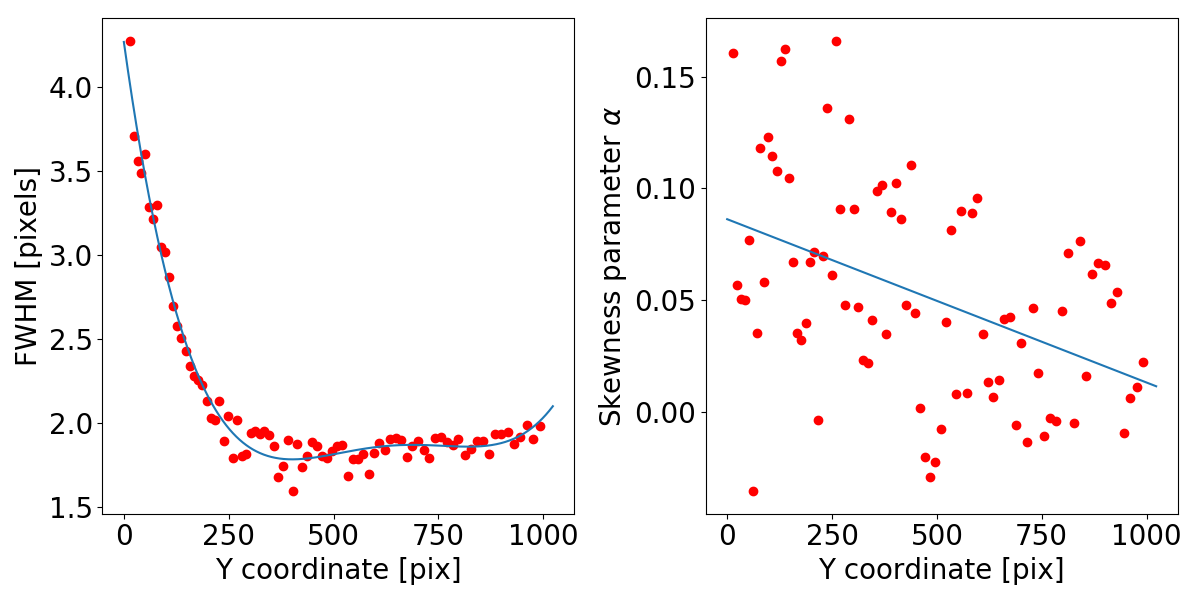

<IPython.core.display.Javascript object>


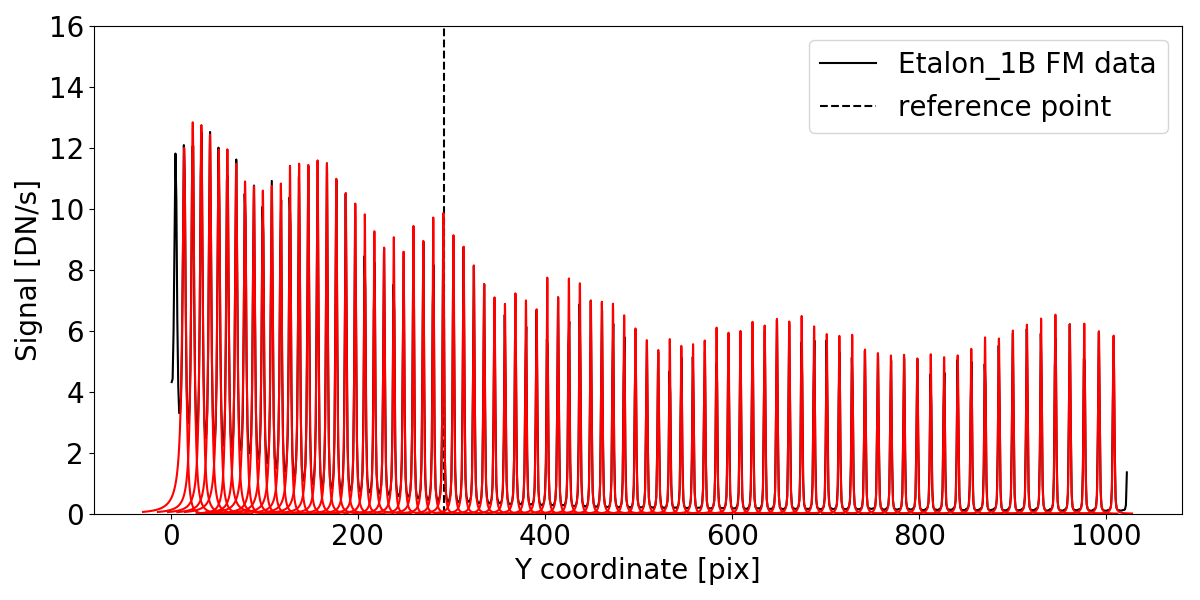

In [17]:
# plot results
sel1 = (np.abs(np.diff(np.array(linefwhm)))<np.inf)
popt1,pcov1 = curve_fit(funcs.order4polyfit,np.array(linecenter)[sel1],np.array(linefwhm)[sel1] )
sel2 = (np.abs(np.diff(np.array(lineskew))<1))
popt2,pcov2 = curve_fit(funcs.straight_line,np.array(linecenter)[sel2],np.array(lineskew)[sel2])

fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].plot(np.array(linecenter)[sel1],np.array(linefwhm)[sel1],'ro')
axs[0].plot(np.arange(det_dims[0]),funcs.order4polyfit(np.arange(det_dims[0]),*popt1))
axs[0].set_xlabel('Y coordinate [pix]',fontsize=20)
axs[0].set_ylabel(r'FWHM [pixels]',fontsize=20)
axs[0].tick_params(axis='both',labelsize=20)
axs[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs[1].plot(np.array(linecenter)[sel2],np.array(lineskew)[sel2],'ro')
axs[1].plot(np.arange(det_dims[0]),funcs.straight_line(np.arange(det_dims[0]),*popt2))
axs[1].set_xlabel('Y coordinate [pix]',fontsize=20)
axs[1].set_ylabel(r'Skewness parameter $\alpha$',fontsize=20)
axs[1].tick_params(axis='both',labelsize=20)
plt.tight_layout()

plt.figure(figsize=(12,6))
plt.plot(etalon1B_fm_data,'k',label='Etalon_1B FM data')
plt.vlines(cutoffpix,0,25,linestyle='dashed',label='reference point')
funcs.plot_etalon_fit(FMetalon1B_fitparams,fitting_flag)
plt.ylim(0,16)
plt.xlabel('Y coordinate [pix]',fontsize=20)
plt.ylabel('Signal [DN/s]',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.legend(loc='upper right',fontsize=20)
plt.tight_layout()

The third step in the wavelength calibration process is to match the reference wavelength/pixel pair determined in step 1 to the "closest" etalon line in the MRS data (in pixel space) and the RAL FTS lab data (in wavelength space). A Euclidean distance is used to determine the proximity of the closest etalon line. Once a common etalon line has been defined between the MRS data and the RAL FTS data, the remaining of the etalon lines on the left and the right of the common etalon line are linked in terms of the line (fitted) central wavelengths and (fitted) central pixels. In this way a collection of wavelength/pixel pairs is defined. This constitutes the wavelength solution of band 1C. One may fit a N-order polynomial through the collection of wavelength/pixel pairs to get a wavelength solution over the MRS detector trace analyzed.

<IPython.core.display.Javascript object>


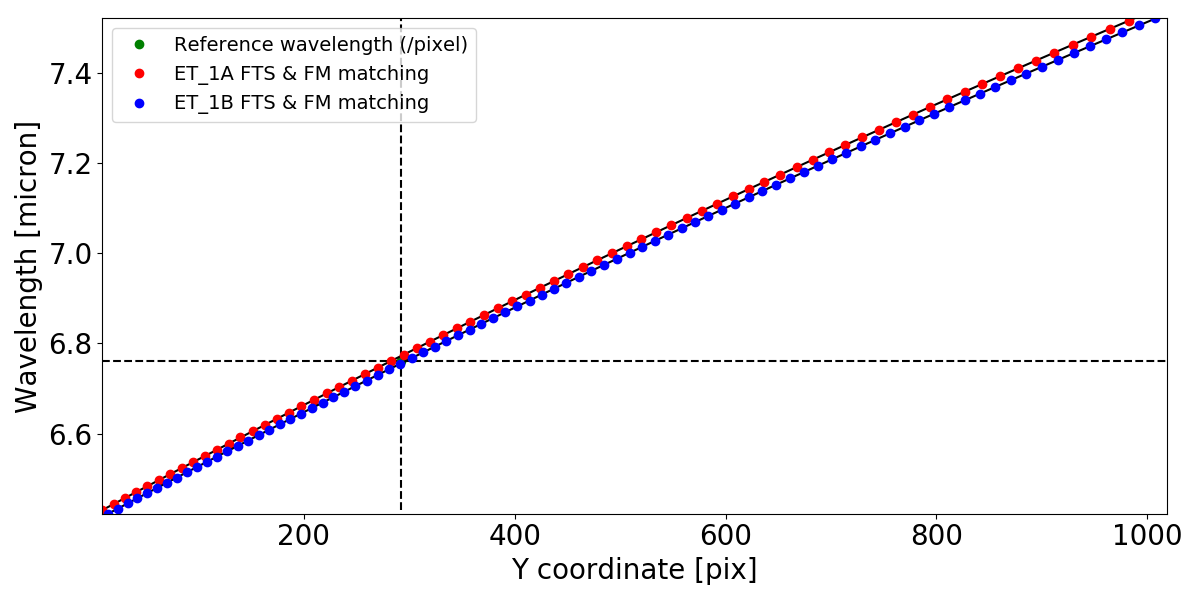

Closest FM ET_1A lines to the reference wavelength (left-right): (282.17-294.53)pix
Closest FM ET_1B lines to the reference wavelength (left-right): (291.37-302.17)pix
Closest FTS ET_1A lines to the reference wavelength (left-right): (6.76-6.77)microns
Closest FTS ET_1B lines to the reference wavelength (left-right): (6.75-6.77)microns


In [18]:
# Find nearest line to reference wavelength
# --All etalon lines
FMetalon1A_linecenters = np.array([FMetalon1A_fitparams[i][1] for i in range(len(FMetalon1A_fitparams))])
FMetalon1B_linecenters = np.array([FMetalon1B_fitparams[i][1] for i in range(len(FMetalon1B_fitparams))])
ET1A_linecenters = fits.open(FTS_ET1A_linefits_file)[1].data['LAMCEN'] # [micron]
ET1B_linecenters = fits.open(FTS_ET1B_linefits_file)[1].data['LAMCEN'] # [micron]

# nearest etalon line to wavelength reference from the left
FMnearestET1Aline_LEFT = np.where(FMetalon1A_linecenters<=cutoffpix)[0][-1]
WaveRef_FMnearestET1Aline_LEFT = FMetalon1A_linecenters[FMnearestET1Aline_LEFT]

FMnearestET1Bline_LEFT = np.where(FMetalon1B_linecenters<=cutoffpix)[0][-1]
WaveRef_FMnearestET1Bline_LEFT = FMetalon1B_linecenters[FMnearestET1Bline_LEFT]

ET1AnearestETline_LEFT = np.where(ET1A_linecenters<=cutofflamb)[0][-1]
WaveRef_ET1AnearestETline_LEFT = ET1A_linecenters[ET1AnearestETline_LEFT]

ET1BnearestETline_LEFT = np.where(ET1B_linecenters<=cutofflamb)[0][-1]
WaveRef_ET1BnearestETline_LEFT = ET1B_linecenters[ET1BnearestETline_LEFT]

# nearest etalon line to wavelength reference from the right
FMnearestET1Aline_RIGHT = FMnearestET1Aline_LEFT+1
WaveRef_FMnearestET1Aline_RIGHT = FMetalon1A_linecenters[FMnearestET1Aline_RIGHT]

FMnearestET1Bline_RIGHT = FMnearestET1Bline_LEFT+1
WaveRef_FMnearestET1Bline_RIGHT = FMetalon1B_linecenters[FMnearestET1Bline_RIGHT]

ET1AnearestETline_RIGHT = ET1AnearestETline_LEFT+1
WaveRef_ET1AnearestETline_RIGHT = ET1A_linecenters[ET1AnearestETline_RIGHT]

ET1BnearestETline_RIGHT = ET1BnearestETline_LEFT+1
WaveRef_ET1BnearestETline_RIGHT = ET1B_linecenters[ET1BnearestETline_RIGHT]

# Match etalon lines
idx_offset = ET1AnearestETline_LEFT-FMnearestET1Aline_LEFT
valid_FTSET1Alines = range(idx_offset,len(FMetalon1A_linecenters)+idx_offset)

idx_offset = ET1BnearestETline_LEFT-FMnearestET1Bline_LEFT
valid_FTSET1Blines = range(idx_offset,len(FMetalon1B_linecenters)+idx_offset)

# plot resulting wavelength solution
plt.figure(figsize=(12,6))
plt.plot(cutoffpix,cutofflamb,'go',label='Reference wavelength (/pixel)')
plt.plot(FMetalon1A_linecenters,ET1A_linecenters[valid_FTSET1Alines],'k')
plt.plot(FMetalon1A_linecenters,ET1A_linecenters[valid_FTSET1Alines],'ro',label='ET_1A FTS & FM matching')
plt.plot(FMetalon1B_linecenters,ET1B_linecenters[valid_FTSET1Blines],'k')
plt.plot(FMetalon1B_linecenters,ET1B_linecenters[valid_FTSET1Blines],'bo',label='ET_1B FTS & FM matching')

plt.hlines(cutofflamb,FMetalon1A_linecenters[0],FMetalon1A_linecenters[-1],linestyle='dashed')
plt.vlines(cutoffpix,ET1A_linecenters[valid_FTSET1Alines].min(),ET1A_linecenters[valid_FTSET1Alines].max(),linestyle='dashed')

plt.xlim(FMetalon1A_linecenters[0],FMetalon1A_linecenters[-1])
plt.ylim(ET1B_linecenters[valid_FTSET1Blines].min(),ET1B_linecenters[valid_FTSET1Blines].max())
plt.xlabel('Y coordinate [pix]',fontsize=20)
plt.ylabel('Wavelength [micron]',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.legend(loc='upper left',fontsize=14)
plt.tight_layout()

print 'Closest FM ET_1A lines to the reference wavelength (left-right): ({}-{})pix'.format(round(WaveRef_FMnearestET1Aline_LEFT,2),round(WaveRef_FMnearestET1Aline_RIGHT,2))
print 'Closest FM ET_1B lines to the reference wavelength (left-right): ({}-{})pix'.format(round(WaveRef_FMnearestET1Bline_LEFT,2),round(WaveRef_FMnearestET1Bline_RIGHT,2))
print 'Closest FTS ET_1A lines to the reference wavelength (left-right): ({}-{})microns'.format(round(WaveRef_ET1AnearestETline_LEFT,2),round(WaveRef_ET1AnearestETline_RIGHT,2))
print 'Closest FTS ET_1B lines to the reference wavelength (left-right): ({}-{})microns'.format(round(WaveRef_ET1BnearestETline_LEFT,2),round(WaveRef_ET1BnearestETline_RIGHT,2))

### Let's look at the systematic offset between the derived wavelength solution and the CDP6 wavelength solution:

<IPython.core.display.Javascript object>


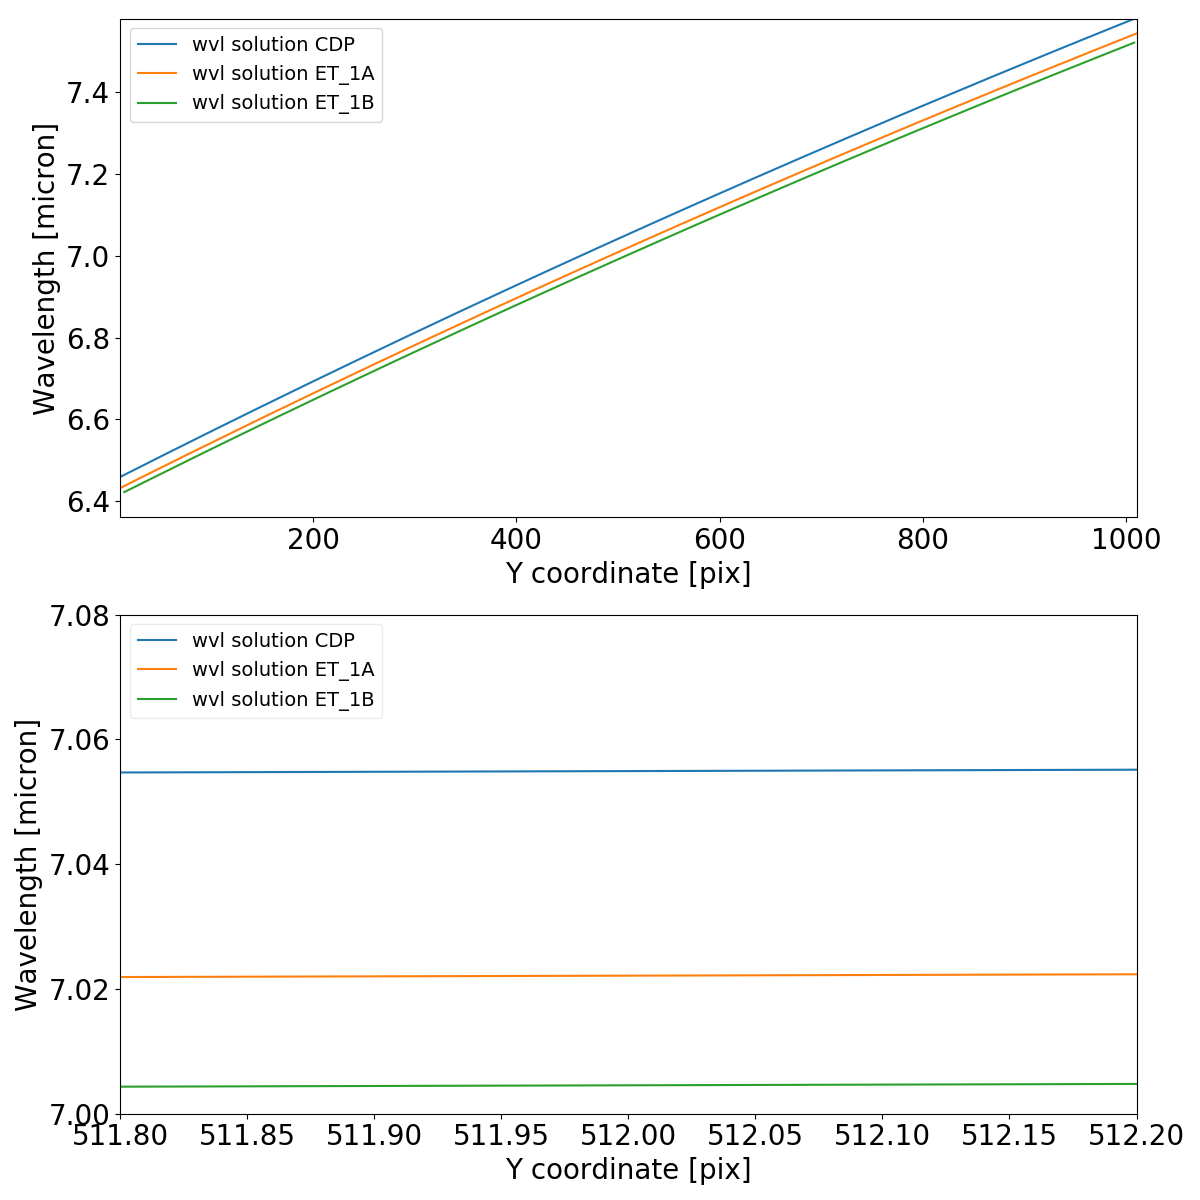

In [19]:
fig,axs = plt.subplots(2,1,figsize=(12,12))
axs[0].plot(np.arange(1024),lambdaMap[ypos,xpos],label='wvl solution CDP')
axs[0].plot(FMetalon1A_linecenters,ET1A_linecenters[valid_FTSET1Alines],label='wvl solution ET_1A')
axs[0].plot(FMetalon1B_linecenters,ET1B_linecenters[valid_FTSET1Blines],label='wvl solution ET_1B')
axs[0].set_xlim(10,1010)
axs[0].set_ylim(6.36,7.58)
axs[0].set_xlabel('Y coordinate [pix]',fontsize=20)
axs[0].set_ylabel('Wavelength [micron]',fontsize=20)
axs[0].tick_params(axis='both',labelsize=20)
axs[0].legend(loc='upper left',fontsize=14)
axs[1].plot(np.arange(1024),lambdaMap[ypos,xpos],label='wvl solution CDP')
axs[1].plot(FMetalon1A_linecenters,ET1A_linecenters[valid_FTSET1Alines],label='wvl solution ET_1A')
axs[1].plot(FMetalon1B_linecenters,ET1B_linecenters[valid_FTSET1Blines],label='wvl solution ET_1B')
axs[1].set_xlim(511.8,512.2)
axs[1].set_ylim(7.0,7.08)
axs[1].set_xlabel('Y coordinate [pix]',fontsize=20)
axs[1].set_ylabel('Wavelength [micron]',fontsize=20)
axs[1].tick_params(axis='both',labelsize=20)
axs[1].legend(loc='upper left',framealpha=0.4,fontsize=14)
plt.tight_layout()